# Bag-of-words document classification

* BoW is the simplest way to do classification: Feature vector goes in, decision falls out.

* Feature vector: a vector with as many dimensions as we have unique features, and a non-zero value set for every feature present in our example
* Binary features: 1/0

In the following we work with the IMDB data, have a look on [how to read it in](read_imdb.ipynb). Here we just read the ready data in.

# IMDB data

* Movie review sentiment positive/negative
* Some 25,000 examples, 50:50 split
* Current state-of-the-art is about 95% accuracy


In [1]:
import json
import random
with open("data/imdb_train.json") as f:
    data=json.load(f)
random.shuffle(data) #play it safe!
print(data[0]) #Every item is a dictionary with `text` and `class` keys, here's the first one:

{'class': 'neg', 'text': '*** Contains Spoilers ***  I did not like this movie at all.  I found it amazingly boring and rather superficially made, irrespective of the importance and depth of the proposed themes: given that eventually we have to die, how should we approach life? In a \\light\\" way, like Tomas; in a \\"heavy\\" way like Tereza; or should we find ways not to face that question, like Sabina? How much is fidelity important in a relationship? How much of the professional life can be mutilated for the sake of our loved ones? How much do we have to be involved in the political life and the social issues of our Country?  Unfortunately, I haven\'t read Kundera\'s novel but after having being let down by the movie I certainly will: I want to understand if the story was ruined by the movie adaptation (which is my guess) or if it was dull from the beginning.  I disagree with most of the positive comments that defined the movie as a masterpiece. I simply don\'t see the reasons why.

To learn on this data, we will need a few steps:

* Build a data matrix with dimensionality (number of examples, number of possible features), and a value for each feature, 0/1 for binary features
* Build a class label matrix (number of examples, number of classes) with the correct labels for the examples, setting 1 for the correct class, and 0 for others

It is quite useless to do all this ourselves, so we will use ready-made classes and functions mostly from scikit

In [2]:
# We need to gather the texts, into a list
texts=[one_example["text"] for one_example in data]
labels=[one_example["class"] for one_example in data]
print(texts[:2])
print(labels[:2])

['*** Contains Spoilers ***  I did not like this movie at all.  I found it amazingly boring and rather superficially made, irrespective of the importance and depth of the proposed themes: given that eventually we have to die, how should we approach life? In a \\light\\" way, like Tomas; in a \\"heavy\\" way like Tereza; or should we find ways not to face that question, like Sabina? How much is fidelity important in a relationship? How much of the professional life can be mutilated for the sake of our loved ones? How much do we have to be involved in the political life and the social issues of our Country?  Unfortunately, I haven\'t read Kundera\'s novel but after having being let down by the movie I certainly will: I want to understand if the story was ruined by the movie adaptation (which is my guess) or if it was dull from the beginning.  I disagree with most of the positive comments that defined the movie as a masterpiece. I simply don\'t see the reasons why. What I see are many fla

In [3]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer=CountVectorizer(max_features=100000,binary=True,ngram_range=(1,1))
feature_matrix=vectorizer.fit_transform(texts)
print("shape=",feature_matrix.shape)


shape= (25000, 74849)


Now we have the feature matrix done! Next thing we need is the class labels to be predicted in one-hot encoding. This means:

* one row for every example
* one column for every possible class label
* exactly one column has 1 for every example, corresponding to the desired class

In [4]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

label_encoder=LabelEncoder() #Turns class labels into integers
one_hot_encoder=OneHotEncoder(sparse=False) #Turns class integers into one-hot encoding
class_numbers=label_encoder.fit_transform(labels)
print("class_numbers shape=",class_numbers.shape)
print("class labels",label_encoder.classes_) #this will let us translate back from indices to labels
#And now yet the one-hot encoding
classes_1hot=one_hot_encoder.fit_transform(class_numbers.reshape(-1,1)) #running without reshape tells you to reshape
print("classes_1hot",classes_1hot)

class_numbers shape= (25000,)
class labels ['neg' 'pos']
classes_1hot [[1. 0.]
 [1. 0.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [0. 1.]]


* The data is ready, we need to build the network now
* Input
* Hidden Dense layer with some kind of non-linearity, and a suitable number of nodes
* Output Dense layer with the softmax activation (normalizes output to distribution) and as many nodes as there are classes

In [5]:
import tensorflow as tf
### Only needed for me, not to block the whole GPU, you don't need this stuff
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
set_session(tf.Session(config=config))
### ---end of weird stuff

from keras.models import Model
from keras.layers import Input, Dense

example_count,feature_count=feature_matrix.shape
example_count2,class_count=classes_1hot.shape
assert example_count==example_count2 #sanity check

inp=Input(shape=(feature_count,))
hidden=Dense(200,activation="tanh")(inp)
outp=Dense(class_count,activation="softmax")(hidden)
model=Model(inputs=[inp], outputs=[outp])

/home/ginter/venv-jupyter/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


...it's **this** simple...!

Once the model is constructed it needs to be compiled, for that we need to know:
* which optimizer we want to use (sgd is fine to begin with)
* what is the loss (categorial_crossentropy for multiclass of the kind we have is the right choice)
* which metrics to measure, accuracy is an okay choice

In [6]:
model.compile(optimizer="sgd",loss="categorical_crossentropy",metrics=['accuracy'])

A compiled model can be fitted on data:

In [7]:
hist=model.fit(feature_matrix,classes_1hot,batch_size=100,verbose=1,epochs=10,validation_split=0.1)

Train on 22500 samples, validate on 2500 samples
Epoch 1/10
22500/22500 [==============================] - 490s 22ms/step - loss: 0.5519 - acc: 0.7796 - val_loss: 0.4692 - val_acc: 0.8240
Epoch 2/10
22500/22500 [==============================] - 81s 4ms/step - loss: 0.4230 - acc: 0.8414 - val_loss: 0.3974 - val_acc: 0.8452
Epoch 3/10
22500/22500 [==============================] - 81s 4ms/step - loss: 0.3685 - acc: 0.8598 - val_loss: 0.3629 - val_acc: 0.8536
Epoch 4/10
22500/22500 [==============================] - 80s 4ms/step - loss: 0.3367 - acc: 0.8700 - val_loss: 0.3414 - val_acc: 0.8628
Epoch 5/10
22500/22500 [==============================] - 251s 11ms/step - loss: 0.3138 - acc: 0.8782 - val_loss: 0.3228 - val_acc: 0.8696
Epoch 6/10
22500/22500 [==============================] - 588s 26ms/step - loss: 0.2963 - acc: 0.8846 - val_loss: 0.3112 - val_acc: 0.8700
Epoch 7/10
22500/22500 [==============================] - 639s 28ms/step - loss: 0.2820 - acc: 0.8923 - val_loss: 0.3022 - 

In [8]:
print(hist.history["val_acc"])

[0.8239999985694886, 0.8452000021934509, 0.8535999989509583, 0.8627999997138978, 0.8696000027656555, 0.8699999976158143, 0.8731999969482422, 0.8743999981880188, 0.8755999970436096, 0.8771999955177308]


* We ran for 10 epochs of training
* Made it to a decent accuracy on the validation data

* But we do not have the model saved, so let's fix that and get the whole thing done
* What constitutes a model (ie what we need to run the model on new data)
  - The feature dictionary in the vectorizer
  - The list of classes in their correct order
  - The structure of the network
  - The weights the network learned

* Do all these things, and run again. This time we also increase the number of epochs to 100, see what happens.

In [9]:
import h5py
from keras.models import Model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint

def save_model(file_name,model,label_encoder,vectorizer):
    """Saves model structure and vocabularies"""
    model_json = model.to_json()
    with open(file_name+".model.json", "w") as f:
        print(model_json,file=f)
    with open(file_name+".vocabularies.json","w") as f:
        classes=list(label_encoder.classes_)
        vocab=dict(((str(w),int(idx)) for w,idx in vectorizer.vocabulary_.items())) #must turn numpy objects to python ones
        json.dump((classes,vocab),f,indent=2)
        
example_count,feature_count=feature_matrix.shape
example_count2,class_count=classes_1hot.shape
assert example_count==example_count2 #sanity check

inp=Input(shape=(feature_count,))
hidden=Dense(200,activation="tanh")(inp)
outp=Dense(class_count,activation="softmax")(hidden)
model=Model(inputs=[inp], outputs=[outp])
# Let's try a different optimizer!
model.compile(optimizer="sgd",loss="categorical_crossentropy",metrics=['accuracy'])

# Save model and vocabularies, can be done before training
save_model("models/imdb_bow",model,label_encoder,vectorizer)
# Callback function to save weights during training, if validation loss goes down
save_cb=ModelCheckpoint(filepath="models/imdb_bow.weights.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

hist=model.fit(feature_matrix,classes_1hot,batch_size=100,verbose=1,epochs=100,validation_split=0.1,callbacks=[save_cb])


Train on 22500 samples, validate on 2500 samples
Epoch 1/100
22500/22500 [==============================] - 606s 27ms/step - loss: 0.5612 - acc: 0.7734 - val_loss: 0.4770 - val_acc: 0.8236

Epoch 00001: val_loss improved from inf to 0.47701, saving model to models/imdb_bow.weights.h5
Epoch 2/100
22500/22500 [==============================] - 696s 31ms/step - loss: 0.4303 - acc: 0.8395 - val_loss: 0.4033 - val_acc: 0.8464

Epoch 00002: val_loss improved from 0.47701 to 0.40333, saving model to models/imdb_bow.weights.h5
Epoch 3/100
22500/22500 [==============================] - 694s 31ms/step - loss: 0.3740 - acc: 0.8581 - val_loss: 0.3654 - val_acc: 0.8520

Epoch 00003: val_loss improved from 0.40333 to 0.36543, saving model to models/imdb_bow.weights.h5
Epoch 4/100
22500/22500 [==============================] - 647s 29ms/step - loss: 0.3406 - acc: 0.8678 - val_loss: 0.3418 - val_acc: 0.8548

Epoch 00004: val_loss improved from 0.36543 to 0.34178, saving model to models/imdb_bow.weight

22500/22500 [==============================] - 13s 597us/step - loss: 0.1163 - acc: 0.9670 - val_loss: 0.2828 - val_acc: 0.8784

Epoch 00040: val_loss did not improve
Epoch 41/100
22500/22500 [==============================] - 23s 1ms/step - loss: 0.1137 - acc: 0.9684 - val_loss: 0.2874 - val_acc: 0.8824

Epoch 00041: val_loss did not improve
Epoch 42/100
22500/22500 [==============================] - 27s 1ms/step - loss: 0.1113 - acc: 0.9692 - val_loss: 0.2894 - val_acc: 0.8800

Epoch 00042: val_loss did not improve
Epoch 43/100
22500/22500 [==============================] - 18s 816us/step - loss: 0.1087 - acc: 0.9703 - val_loss: 0.2874 - val_acc: 0.8816

Epoch 00043: val_loss did not improve
Epoch 44/100
22500/22500 [==============================] - 14s 608us/step - loss: 0.1066 - acc: 0.9709 - val_loss: 0.2909 - val_acc: 0.8804

Epoch 00044: val_loss did not improve
Epoch 45/100
22500/22500 [==============================] - 14s 604us/step - loss: 0.1044 - acc: 0.9716 - val_loss: 0


Epoch 00085: val_loss did not improve
Epoch 86/100
22500/22500 [==============================] - 14s 603us/step - loss: 0.0468 - acc: 0.9934 - val_loss: 0.3607 - val_acc: 0.8744

Epoch 00086: val_loss did not improve
Epoch 87/100
22500/22500 [==============================] - 14s 604us/step - loss: 0.0461 - acc: 0.9940 - val_loss: 0.3611 - val_acc: 0.8768

Epoch 00087: val_loss did not improve
Epoch 88/100
22500/22500 [==============================] - 14s 603us/step - loss: 0.0452 - acc: 0.9944 - val_loss: 0.3648 - val_acc: 0.8740

Epoch 00088: val_loss did not improve
Epoch 89/100
22500/22500 [==============================] - 14s 606us/step - loss: 0.0445 - acc: 0.9943 - val_loss: 0.3651 - val_acc: 0.8768

Epoch 00089: val_loss did not improve
Epoch 90/100
22500/22500 [==============================] - 14s 604us/step - loss: 0.0438 - acc: 0.9944 - val_loss: 0.3677 - val_acc: 0.8732

Epoch 00090: val_loss did not improve
Epoch 91/100
22500/22500 [==============================] - 1

**Corrected answer to a lecture question** why the training set accuracy is smaller on first epoch than the validation set accuracy.

My quick answer was not correct. Given a little more time to think, what happens is this: The training set accuracy is calculated from the beginning, when the network is randomly initialized and doesn't really do anything. The validation accuracy is calculated only after the first epoch, when the network already learned for one full epoch. That is why the number on validation set can be higher.

In [10]:
import numpy
from sklearn.metrics import classification_report, confusion_matrix

#Validation data used during training:
val_instances,val_labels_1hot,_=hist.validation_data

print("Network output=",model.predict(val_instances))
predictions=numpy.argmax(model.predict(val_instances),axis=1)
print("Maximum class for each example=",predictions)
gold=numpy.nonzero(val_labels_1hot)[1] #undo 1-hot encoding
conf_matrix=confusion_matrix(list(gold),list(predictions))
print("Confusion matrix=\n",conf_matrix)
### FIXED VERSION (thanks for reporting the bug during the lecture!)
### 
gold_labels=label_encoder.inverse_transform(list(gold))
predicted_labels=label_encoder.inverse_transform(list(predictions))
#print("Gold labels=",gold_labels)
#print("Predicted labels=",predicted_labels)
print(classification_report(gold_labels,predicted_labels))


Network output= [[9.99880433e-01 1.19501674e-04]
 [4.34341507e-10 1.00000000e+00]
 [7.21750723e-07 9.99999285e-01]
 ...
 [9.99235392e-01 7.64620898e-04]
 [6.95837021e-01 3.04162979e-01]
 [9.22101676e-01 7.78983310e-02]]
Maximum class for each example= [0 1 1 ... 0 0 0]
Confusion matrix=
 [[1109  152]
 [ 159 1080]]
             precision    recall  f1-score   support

        neg       0.87      0.88      0.88      1261
        pos       0.88      0.87      0.87      1239

avg / total       0.88      0.88      0.88      2500



/home/ginter/venv-jupyter/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ginter/venv-jupyter/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


# Learning progress

* The history object we get lets us inspect the accuracy during training
* Remarks:
  - Accuracy on training data keeps going up
  - Accuracy on validation (test) data flattens out after a but over 10 epochs, we are learning very little past that point
  - What we see is the network keeps overfitting on the training data to the end

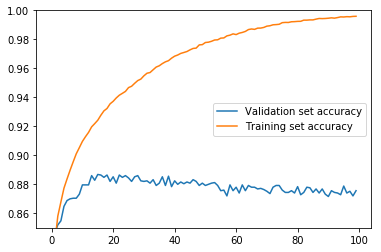

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
#print(hist.history["val_acc"])
plt.ylim(0.85,1.0)
plt.plot(hist.history["val_acc"],label="Validation set accuracy")
plt.plot(hist.history["acc"],label="Training set accuracy")
plt.legend()
plt.show()

# Summary

* We put together a program to train a neural network classifier for sentiment detector
* We learned the necessary code/techniques to save models, and feed the training with data in just the right format
* We observed the training across epochs
* We saw how the classifier can be applied to various text classification problems
* The IMDB sentiment classifier ended up at nearly 90% accuracy, the state of the art is about 95%, we got surprisingly far in few lines of code
